In [1]:
import subprocess
import numpy as np
import simplifier
import csv
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import rc
import matplotlib.cm as cm
import matplotlib as mpl
import sympy
import sys

sys.path.insert(0, 'Pantheon/')
import test_all
from sympy_symbols import *
from likelihood import CCLikelihood, PanthLikelihood

In [2]:
print('Making CC Likelihood')
cc_like = CCLikelihood()
print('Making Pantheon Likelihood')
panth_like = PanthLikelihood()

Making CC Likelihood
Making Pantheon Likelihood


# Figure 2 - Number of functions vs Complexity

In [ ]:
def file_len(fname):
    p = subprocess.Popen(['wc', '-l', fname], stdout=subprocess.PIPE,
                                              stderr=subprocess.PIPE)
    result, err = p.communicate()
    if p.returncode != 0:
        raise IOError(err)
    return int(result.strip().split()[0])


def count_fun(fname):

    ntotal = file_len(fname)
    with open(fname, "r") as f:
        all_fun = f.read().splitlines()
    assert ntotal == len(all_fun), 'Maybe missing some equations'
    max_param = simplifier.get_max_param(all_fun, verbose=False)
    nparam = simplifier.count_params(all_fun, max_param)
    count = np.empty(max_param + 1, dtype=int)
    for i in range(len(count)):
        count[i] = (nparam == i).sum()
    assert ntotal == count.sum(), 'Count does not match total'

    return count

all_compl = np.arange(4, 11)
# all_compl = np.arange(4, 8)
# all_dirname = ['core_maths/', 'osc_maths/', 'ext_maths/']
# all_ops = [r'Core = $\{x, a, {\rm inv}, +, -, \times, \div, {\rm pow} \}$',
#           r'Core + $\{ \sin \}$',
#           r'Core + $\{ {\rm square}, \exp, \sqrt{\cdot} \}$']
all_dirname = ['core_maths/']
all_ops = [r'$\{x, a, {\rm inv}, +, -, \times, \div, {\rm pow} \}$']

nfortab = 4

# fig, axs = plt.subplots(1, 3, figsize=(10,3), sharey=True)
fig, axs = plt.subplots(1, 1, figsize=(5,4))
axs = [axs]
cm = plt.get_cmap('Set1')

for i in range(len(all_dirname)):
    
    dirname = all_dirname[i]
    ops = all_ops[i]

    all_total = []
    all_uniq = []
    
    print(dirname)

    for compl in all_compl:

        print(compl)

        try:
            fname = dirname + '/compl_%i/all_equations_%i.txt'%(compl,compl)
            total_count = count_fun(fname)

            fname = dirname + '/compl_%i/unique_equations_%i.txt'%(compl,compl)
            uniq_count = count_fun(fname)

            if (len(uniq_count) < nfortab+1) or (len(total_count) < nfortab+1):
                t = np.zeros(nfortab+1, dtype=int)
                t[:len(uniq_count)] = uniq_count
                uniq_count = t

                t = np.zeros(nfortab+1, dtype=int)
                t[:len(total_count)] = total_count
                total_count = t

            all_total.append([x for x in total_count[:nfortab+1]])
            all_uniq.append([x for x in uniq_count[:nfortab+1]])

        except:
            pass


    all_total = np.array(all_total, dtype=int)
    all_uniq = np.array(all_uniq, dtype=int)
    
    for j in range(all_total.shape[1]):
        c = cm(j)
        axs[i].plot(all_compl[:all_total.shape[0]], all_total[:,j], color=c, marker='.', label=r'$p = %i$'%j)
        axs[i].plot(all_compl[:all_total.shape[0]], all_uniq[:,j], color=c, ls='--', marker='.')
        
    axs[i].set_xlabel('Complexity')
    axs[i].set_title(ops)
    
    axs[i].set_xticks(all_compl)
    axs[i].set_xticklabels(all_compl)

axs[0].set_yscale('symlog')
axs[0].set_ylabel('Number of Functions')
axs[0].set_ylim(0, None)

fig.tight_layout()
fig.subplots_adjust(hspace=0)

# axs[int(np.floor(len(axs)/2))].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=nfortab+1, fancybox=True)
axs[int(np.floor(len(axs)/2))].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=nfortab+1, fancybox=True)
fig.savefig('figs/count_functions.pdf', bbox_inches='tight', transparent=True)

# Figures 3&4 - Data Comparison

	 0 10
	 1 10
	 2 10
	 3 10
	 4 10
	 5 10
	 6 10
0.0 2.37746932223979
0 of 10


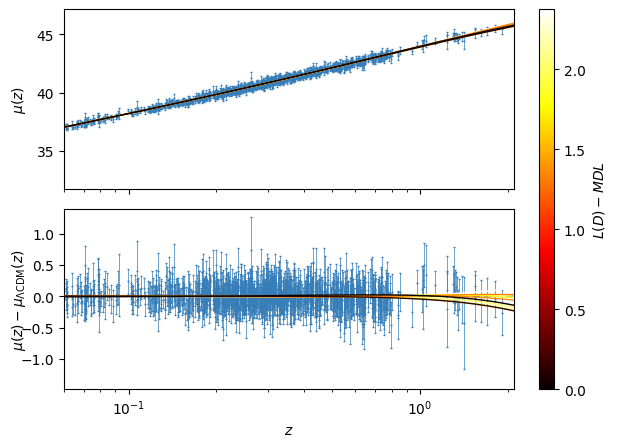

In [4]:
def data_comparison(likelihood, nfun, ylabel1, ylabel2, savename):

    xplot = np.logspace(np.log10(6e-2), np.log10(2.1), 1000) + 1
    tmax = 5

    # GET LCDM FUNCTION
    fcn_i = 'a0 * pow(x, 3) + a1'
    fcn_i, eq, integrated = likelihood.run_sympify(fcn_i, tmax=tmax, try_integration=False)

    if 'a3' in fcn_i:
        k = 4
        eq_numpy = sympy.lambdify([x, a0, a1, a2, a3], eq, modules=["numpy","sympy"])
    elif 'a2' in fcn_i:
        k = 3
        eq_numpy = sympy.lambdify([x, a0, a1, a2], eq, modules=["numpy","sympy"])
    elif 'a1' in fcn_i:
        k = 2
        eq_numpy = sympy.lambdify([x, a0, a1], eq, modules=["numpy","sympy"])
    elif 'a0' in fcn_i:
        k = 1
        eq_numpy = sympy.lambdify([x, a0], eq, modules=["numpy","sympy"])
    else:
        k = 0
        eq_numpy = sympy.lambdify([x], eq, modules=["numpy","sympy"])

    chi2, p = test_all.optimise_fun(fcn_i, likelihood, tmax, 0, 4, try_integration=False)
    print(chi2, p)

    likelihood.clear_data()
    ylcdm_var = likelihood.get_pred(likelihood.xvar, p[:k], eq_numpy, integrated=integrated)
    likelihood.clear_data()
    ylcdm_plot = likelihood.get_pred(xplot, p[:k], eq_numpy, integrated=integrated)

    # GET OTHER FUNCTIONS
    all_compl = np.arange(3, 9)
    fcn_list = []
    all_DL = []
    params = []

    for i, compl in enumerate(all_compl):
        fname = likelihood.out_dir + '/final_%i.dat'%compl
        with open(fname, "r") as f:
            reader = csv.reader(f, delimiter=';')
            data = [row for row in reader]
        fcn_list += [d[1] for d in data]
        all_DL += [d[2] for d in data]
        params += [d[7:] for d in data]

    all_DL = np.array(all_DL, dtype=float)
    params = np.array(params, dtype=float)
    m = np.isfinite(all_DL)
    all_DL = all_DL[m]
    params = params[m,:]
    fcn_list = [fcn_list[i] for i in range(len(fcn_list)) if m[i]]
    MDL = np.amin(all_DL)

    # Take top nfun functions
    idx = np.argsort(all_DL)[:min(nfun, len(all_DL))]
    all_DL = all_DL[idx] - MDL
    params = params[idx,:]
    fcn_list = [fcn_list[i] for i in idx]

    fig  = plt.figure(figsize=(5,4))
    ax1  = fig.add_axes([0.0,0.50,0.9,0.45])
    ax2  = fig.add_axes([0.0,0.0,0.9,0.45])
    ax3  = fig.add_axes([0.95,0.00,0.03,0.95])
    ax1.get_shared_x_axes().join(ax1, ax2)

    cmap = cm.hot
    vmin = all_DL.min()
    vmax = all_DL.max()
    norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
    print(vmin, vmax)

    max_param = 4
    tmax = 5
    
    likelihood.clear_data()
    
    for i in range(len(fcn_list)):

        fcn_i = fcn_list[i].replace('\'', '')

        k = simplifier.count_params([fcn_i], max_param)[0]
        measured = params[i,:k]
        
        if i%10 == 0:
            print('%i of %i'%(i,len(fcn_list)))

        try:
            fcn_i, eq, integrated = likelihood.run_sympify(fcn_i, tmax=tmax)
            if k == 0:
                eq_numpy = sympy.lambdify([x], eq, modules=["numpy","sympy"])
            elif k==1:
                eq_numpy = sympy.lambdify([x, a0], eq, modules=["numpy","sympy"])
            elif k==2:
                eq_numpy = sympy.lambdify([x, a0, a1], eq, modules=["numpy","sympy"])
            elif k==3:
                eq_numpy = sympy.lambdify([x, a0, a1, a2], eq, modules=["numpy","sympy"])
            elif k==4:
                eq_numpy = sympy.lambdify([x, a0, a1, a2, a3], eq, modules=["numpy","sympy"])
            ypred_plot = likelihood.get_pred(xplot, measured, eq_numpy, integrated=integrated)
        except:
            fcn_i, eq, integrated = run_sympify(fcn_i, tmax=tmax, try_integration=False)
            if k == 0:
                eq_numpy = sympy.lambdify([x], eq, modules=["numpy","sympy"])
            elif k==1:
                eq_numpy = sympy.lambdify([x, a0], eq, modules=["numpy","sympy"])
            elif k==2:
                eq_numpy = sympy.lambdify([x, a0, a1], eq, modules=["numpy","sympy"])
            elif k==3:
                eq_numpy = sympy.lambdify([x, a0, a1, a2], eq, modules=["numpy","sympy"])
            elif k==4:
                eq_numpy = sympy.lambdify([x, a0, a1, a2, a3], eq, modules=["numpy","sympy"])
            ypred_plot = likelihood.get_pred(xplot, measured, eq_numpy, integrated=integrated)

        colour = cmap(norm(all_DL[i]))
        plot_kwargs = {'color':colour, 'zorder':len(fcn_list)-i, 'lw':1}

        ax1.plot(xplot-1, ypred_plot, **plot_kwargs)
        ax2.plot(xplot-1, ypred_plot-ylcdm_plot, **plot_kwargs)

    cmvar = plt.get_cmap('Set1')
    plot_kwargs = {'fmt':'.', 'markersize':1, 'zorder':-1, 
                 'capsize':1, 'elinewidth':0.5, 'color':cmvar(1), 'alpha':1}

    ax1.errorbar(likelihood.xvar-1, likelihood.yvar, yerr=likelihood.yerr, **plot_kwargs)
    ax2.errorbar(likelihood.xvar-1, likelihood.yvar-ylcdm_var, yerr=likelihood.yerr, **plot_kwargs)
    ax2.axhline(y=0, color=cmvar(1), ls='--')

    ax2.set_xlabel(r'$z$')
    ax1.set_ylabel(ylabel1)
    ax2.set_ylabel(ylabel2)

    ax1.set_xlim(xplot.min()-1, xplot.max()-1)
    ax1.set_xscale('log')
    ax1.set_xticklabels([])

    cb1 = mpl.colorbar.ColorbarBase(ax3,cmap=cmap,norm=norm,orientation='vertical')
    cb1.set_label(r'$L \left( D \right) - MDL$')

    fig.align_ylabels([ax1, ax2])
    fig.tight_layout()

    ax1.get_yaxis().set_label_coords(-0.08,0.5)
    ax2.get_yaxis().set_label_coords(-0.08,0.5)

    fig.savefig(savename, bbox_inches='tight', transparent=True)
    
    return

data_comparison(cc_like, 
                100, 
                r'$H \left( z \right) \ / \ H_0$', 
                r'$\left( H \left( z \right) - H_{\rm \Lambda CDM} \left( z \right) \right) \ / \ H_0$', 
                'figs/cc_prediction.pdf')

data_comparison(panth_like, 
                10, 
                r'$\mu \left( z \right)$', 
                r'$\mu \left( z \right) - \mu_{\rm \Lambda CDM} \left( z \right)$', 
                'figs/pantheon_prediction.pdf')


# Figure 4 - Pareto Front Comparison 

/mnt/zfsusers/deaglan/symbolic_regression/brute_force/simplify_brute/Pantheon/output_panth/
BEST FUNCTION (MDL): ['a0 + pow(x,x)', ['0.19592785', '0.0', '0.0', '0.0']]
BEST FUNCTION (logL): ['a0 - x + pow(x,a1)', ['1.1793247', '2.188762', '0.0', '0.0']]
/mnt/zfsusers/deaglan/symbolic_regression/brute_force/simplify_brute/Pantheon/output_cc/
BEST FUNCTION (MDL): ['pow(x,(pow(x,a0)))', ['0.7161692', '0.0', '0.0', '0.0']]
BEST FUNCTION (logL): ['1/(a0 + pow(Abs(a1),(pow(Abs(a2),x))))', ['0.17060539', '-0.96293526', '8.0563284', '0.0']]


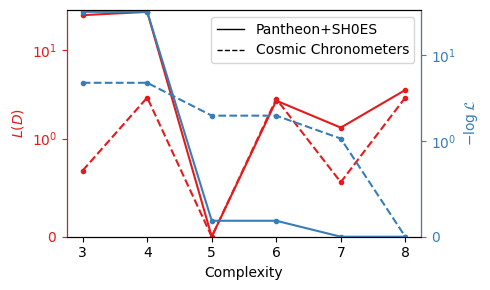

In [5]:
root_dirname = '/mnt/zfsusers/deaglan/symbolic_regression/brute_force/simplify_brute/Pantheon/'

all_dirname = ['output_panth/', 'output_cc/']
all_ls = ['-', '--']
line_labels = ['Pantheon+SH0ES', "Cosmic Chronometers"]

# all_dirname = ['output_cc/']
# all_ls = ['-']
# line_labels = ["Cosmic Chronometers"]

all_compl = np.arange(3, 9)
               
fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
ax2 = ax1.twinx()
cm = plt.get_cmap('Set1')
               
for k in range(len(all_dirname)):
               
    dirname = root_dirname + all_dirname[k]
    print(dirname)
               
    DL = np.empty(len(all_compl))
    logL = np.empty(len(all_compl))
    DL_fun = [None] * len(all_compl)
    logL_fun = [None] * len(all_compl)

    for i, compl in enumerate(all_compl):
        fname = dirname + 'final_%i.dat'%compl
        with open(fname, "r") as f:
            reader = csv.reader(f, delimiter=';')
            data = [row for row in reader]
            ll = np.array([d[4] for d in data], dtype=float)
            j = np.nanargmin(ll)
            logL[i] = ll[j]
            logL_fun[i] = [data[j][1], data[j][7:]]

        DL[i] = data[0][2]
        DL_fun[i] = [data[0][1], data[0][7:]]

    print('BEST FUNCTION (MDL):', DL_fun[np.argmin(DL)])
    print('BEST FUNCTION (logL):', logL_fun[np.argmin(logL)])
    
    DL -= np.amin(DL)
    logL -= np.amin(logL)

    ax1.plot(all_compl, DL, marker='.', color=cm(0), ls=all_ls[k])
    ax2.plot(all_compl, logL, marker='.', color=cm(1), ls=all_ls[k])
    

ax1.set_ylabel(r'$L \left( D \right)$')
ax1.set_xticks(all_compl)
ax1.set_xticklabels(all_compl);
ax1.set_xlabel(r'Complexity')
               
ax2.set_ylabel(r'$ - \log\mathcal{L}$')
ax1.yaxis.label.set_color(cm(0))
ax1.tick_params(axis='y', colors=cm(0))
ax2.spines['left'].set_color(cm(0))

ax2.yaxis.label.set_color(cm(1))
ax2.tick_params(axis='y', colors=cm(1))
ax2.spines['right'].set_color(cm(1))

custom_lines = []
for i in range(len(all_ls)):
    custom_lines.append(Line2D([0], [0], color='k', lw=1, ls=all_ls[i]))
    
ax1.legend(custom_lines, line_labels, fancybox=True)
ax1.set_yscale('symlog', linthresh=1)
ax1.set_ylim(0, None)
ax2.set_yscale('symlog', linthresh=1)
ax2.set_ylim(0, None)
                
fig.tight_layout()
    

# Tabulate the Best Functions

In [6]:
root_dirname = '/mnt/zfsusers/deaglan/symbolic_regression/brute_force/simplify_brute/Pantheon/'
all_dirname = ['output_panth/', 'output_cc/']

all_dirname = [root_dirname + d for d in all_dirname]

for dirname in all_dirname:

    all_compl = np.arange(3, 9)

    nrow = 5

    DL = []
    logL = []
    fun = []
    params = []

    for i, compl in enumerate(all_compl):
        fname = dirname + 'final_%i.dat'%compl
        with open(fname, "r") as f:
            reader = csv.reader(f, delimiter=';')
            data = [row for row in reader]

            DL += [d[2] for d in data]
            logL += [d[4] for d in data]
            fun += [d[1] for d in data]
            params += [d[7:] for d in data]

    DL = np.array(DL, dtype=float)
    logL = np.array(logL, dtype=float)
    params = np.array(params, dtype=float)

    m = np.argsort(DL)
    DL = DL[m]
    logL = logL[m]
    params = params[m,:]
    fun = [fun[i] for i in m]

    x, y = sympy.symbols('x y', positive=True)                  # The variables, which are always +ve here
    a0, a1, a2, a3 = sympy.symbols('a0 a1 a2 a3', real=True)    # The constants, which can be -ve
    sympy.init_printing(use_unicode=True)
    inv = sympy.Lambda(x, 1/x)
    square = sympy.Lambda(x, x*x)
    cube = sympy.Lambda(x, x*x*x)
    sqrt = sympy.Lambda(x, sympy.sqrt(sympy.Abs(x, evaluate=False)))
    log = sympy.Lambda(x, sympy.log(sympy.Abs(x, evaluate=False)))
    pow = sympy.Lambda((x,y), sympy.Pow(sympy.Abs(x, evaluate=False), y))

    sympy.init_printing(use_latex=True)

    # CONVERT TO LATEX
    # for i in range(nrow):
    from sympy.printing.latex import LatexPrinter
    texprinter = LatexPrinter()

    form = 'c|c|c|c'
    labs = 'Rank & Function & $L\\left(D\\right)$ & $-\\log\\mathcal{L}$'
    for i in range(params.shape[1]):
        form += '|c'
        labs += ' & $\\theta_{%i}$'%i
    labs += '\\\\'

    print('\t\t\\begin{tabular}{%s}'%form)
    print('\t\t\\hline')
    print('\t\t' + labs)

    for i in range(nrow):

        fcn_i = fun[i]
        fcn_i = fcn_i.replace('\n', '')
        fcn_i = fcn_i.replace('\'', '')

        eq = sympy.sympify(fcn_i,
                        locals={"inv": inv,
                                "square": square,
                                "cube": cube,
                                "sqrt": sqrt,
                                "log": log,
                                "pow": pow,
                                "x": x,
                                "a0": a0,
                                "a1": a1,
                                "a2": a2})
        f = texprinter.doprint(eq)
        f = '$' + f.replace('a_', '\\theta_') + '$'

        if 'a3' in fcn_i:
            npar = 4
        elif 'a2' in fcn_i:
            npar = 3
        elif 'a1' in fcn_i:
            npar = 2
        elif 'a0' in fcn_i:
            npar = 1
        else:
            npar = 0

        s = ''
        for j in range(len(params[i,:])):
            if j < npar:
                s += '%.2f & '%params[i,j]
            else:
                s += '- & '
        s = s[:-2]
        s = '\t\t\t%i & %s & %.2f & %.2f & %s \\\\'%(i+1, f, DL[i], logL[i], s)

        print(s)

    print('\t\t\\hline') 
    print('\t\t\\end{tabular}')

    print('\n\n')


		\begin{tabular}{c|c|c|c|c|c|c|c}
		\hline
		Rank & Function & $L\left(D\right)$ & $-\log\mathcal{L}$ & $\theta_{0}$ & $\theta_{1}$ & $\theta_{2}$ & $\theta_{3}$\\
			1 & $\theta_{0} + x^{x}$ & 716.48 & 706.33 & 0.20 & - & - & -  \\
			2 & $\left|{\theta_{0} + x}\right|^{x}$ & 716.59 & 706.44 & 0.18 & - & - & -  \\
			3 & $x \left|{\theta_{0}}\right|^{x^{2}}$ & 717.81 & 702.77 & 1.16 & - & - & -  \\
			4 & $\left|{\theta_{0} + x}\right|^{x^{\theta_{1}}}$ & 717.84 & 702.68 & 0.18 & 0.82 & - & -  \\
			5 & $\theta_{0} x^{x}$ & 718.22 & 706.18 & 1.18 & - & - & -  \\
		\hline
		\end{tabular}



		\begin{tabular}{c|c|c|c|c|c|c|c}
		\hline
		Rank & Function & $L\left(D\right)$ & $-\log\mathcal{L}$ & $\theta_{0}$ & $\theta_{1}$ & $\theta_{2}$ & $\theta_{3}$\\
			1 & $x^{x^{\theta_{0}}}$ & 15.33 & 7.91 & 0.72 & - & - & -  \\
			2 & $x^{x^{x^{\theta_{0}}}}$ & 15.88 & 7.38 & -0.38 & - & - & -  \\
			3 & $x^{\theta_{0}}$ & 16.00 & 10.34 & 1.73 & - & - & -  \\
			4 & $x^{\theta_{0}}$ & 16.00 & 10